# Машинное обучение, ФКН ВШЭ

# Практическое задание 4

### Общая информация

Дата выдачи: 28 октября 2019

Мягкий дедлайн: 7:59MSK 11 ноября 2019 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13 ноября 2019.

### О задании

В этом задании вы:
- настроите метод опорных векторов, визуализируете опорные вектора
- познакомитесь с калибровочными кривыми и сравните вероятности, выдаваемые логистической регрессией и методом опорных векторов
- изучите методы работы с категориальными переменными
- в качестве бонуса попробуете библиотеку vowpal wabbit.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка:** ...

In [9]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


## Часть 1. Метод опорных векторов и калибровка вероятностней

Сгенерируем синтетические данные.

In [36]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=42)
print(X_train.shape,'\n', X_test.shape)

(20000, 20) 
 (80000, 20)


__Задание 1.__ Обучение и применение метода опорных векторов.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили обычный вариант, что соответствует линейному ядру (LinearSVC/LinearSVR в scikit-learn).

### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train, y_train)
#print(clf.coef_)

In [37]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression

# обучим логистическую регрессию
svc = LinearSVC()
lr = lr.fit(X_train, y_train)

C:\Users\Olya\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые.

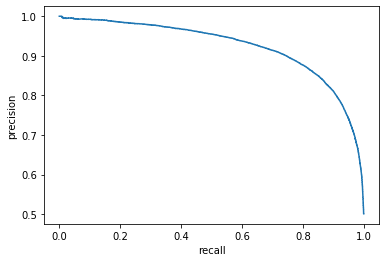

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [39]:
from sklearn.metrics import auc
auc(recall, precision)

0.9242811536222946

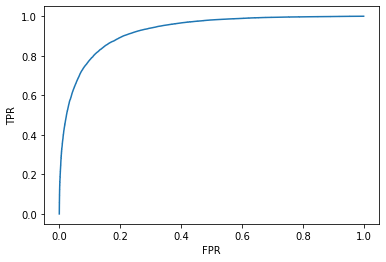

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [41]:
auc(fpr, tpr)

0.9260762976218009

В названии метода присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью make_classification с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут support\_vectors\_). В этот раз вместо LinearSVC воспользуйтесь SVC с линейным ядром (kernel='linear'), так как только в нём есть информация об опорных векторах.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Задание 2.__ Калибровка вероятностей.

__(1.5 балла)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l - r) / 2)
        bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios)

Постройте калибровочные кривые для логистической регрессии и метода опорных векторов. Изучите распределение ответов классификаторов (постройте гистограммы с помощью plt.hist). Чем они различаются? Чем вы можете объяснить это?

Заметим, что метод опорных векторов не умеет predict_proba, но имеет метод decision_function.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Воспользуйтесь CalibratedClassifierCV из sklearn для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Бонусное задание (1 балл).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 2. Работа с категориальными переменными

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с прошлогоднего конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом под нужды задания мы немного модифицируем датасет.

In [ ]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [ ]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

__Задание 3.__ Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

__(0 баллов)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Задание 4.__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

__(0.5 балла)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5.__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментов. Заметили ли вы что-то интересное?

__(1.5 балла)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(1 балл)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__(Бонусная часть)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 

__(+0.5 балла)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — среднее значение целевой переменной по всей выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значении. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

__Задание 7.__ Добавьте сглаживание, описанное выше и повторите эксперименты.

__(1 балл)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием, вы заметили.

__Ответ:__ ...

## Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [ ]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 8.__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

__(0.5 балла)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

__Задание 9.__ Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

__(0.5 балла)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### Методы-обёртки

__Задание 10.__ 

__(1 балл)__

Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо. 

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** ...

## Настройка порога для бинаризации вероятностей

В этой части мы будем проделывать стандартные операции для подготовки модели к её реальному использованию — подбора порога для бинаризации вероятностей с учётом потребностей бизнеса или продукта. Хороший алгоритм с точки зрения ROC-AUC это, конечно, хорошо, но ведь в реальности нам надо принимать решение бинарно, например, выдавать ли кредит человеку. 

Воспользуемся той же самый задачей, что и в предыдущем разделе — определение обращение клиента в страховую в ближайшее время. Положительные объекты в нашей выборки как раз обратившиеся в страховую клиенты. 

Не вдаваясь в подробности бизнеса страховых, можно понять, что обращение клиента по страховому случаю для нас как страховой невыгодно, ведь мы теряем на этом деньги. Клиенты, которые не обращаются в страховую и ездят аккуратно, приносят нам деньги.

Пусть на каждом клиенте, который обратился в нашу страховую, мы теряем 100000, а на клиенте, который не обратился в страховую, мы зарабатываем 5000. 

Будем строить алгоритм, который прогнозирует обращение по страховому случаю, чтобы некоторым потенциальным клиентам отказывать в обслуживании, если мы уверены, что на них мы потеряем деньги.

In [ ]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

В этот раз мы не будем сэмплировать данные и будем использовать их "как есть".

Посчитайте долю положительных примеров в выборке? Скажите, почему она такая?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

В качестве нашей основной модели будем использовать логистическую регрессию, которая возвращает вероятность положительного класса. Обучите модель, сделайте предсказания на тестовой выборке.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Посчитайте ROC-AUC. Что вы можете про него сказать? Как вы считаете, почему получилось так?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Постройте precision-recall кривую на тестовой выборке. Что вы можете по ней сказать?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

У нас есть алгоритм, который определяет вероятность обращения клиента по страховому случаю, но мы хотим использовать этот алгоритм, чтобы отказывать клиентам в обслуживании в страховой. Для этого нам нужны бинарные предсказания алгоритма. Давайте искать этот порог для получения бинарных предсказаний.

__Задание 11.__

__(0.5 балла)__

Предположим, что нам надо подобрать порог такой, чтобы среди наших положителных предсказаний 95\% действительно обратились бы по страховому случаю. Подберите соответствующий порог, оцените на нём precision, recall. Скажите, какой части потенциальных клиентов мы откажем?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Иногда сложно решить, какие значения precision и recall нужны в нашей задаче. Однако иногда можно оценить экономический эффект от нашего алгоритма. Мы знаем, во сколько нам обходится клиент, который обратился в страховую, и сколько нам приносит клиент, который не обратился. 

При фиксированном пороге мы знаем, кому мы бы отказали в обслуживании. Среди них есть те, кто обратился бы в страховую и нам пришлось бы потратить деньги, и те, кто не обратился бы, то есть принёс бы нам деньги. Мы можем посчитать разницу между нашими доходами и расходами от этой группы людей и надеяться, что она будет положительной. 

__Задание 12.__ Найдите такой порог, при котором наш баланс (разница между доходами и расходами на группе клиентов, которым мы отказали) неотрицательный. 

__(1 балл)__

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

А на каком значение порога это разнциа максимальна? Скольким клиентам мы отказали в обслуживании?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 3 (бонус). Vowpal Wabbit

В этой части мы научимся использовать библиотеку [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit). У неё есть несколько особенностей:
- можно обучать только линейные модели, но за счёт большого количества опций и возможностей по усложнению, можно построить и довольно сложные вещи
- можно обучаться на выборках, которые не помещаются в оперативную память
- можно обрабатывать большое количество признаков (например, мешки слов текстов) и "на ходу" строить на них комбинации (не переделывать датасет)
- другие особенности, как например, активное обучение и возможность распараллеленного обучения.

Основные особенности при использовании следующие:
- Свой формат данных: "label |A feature1:value1 |B feature2:value2", позволяющий, во-первых, указывать не все признаки (не нужно хранить много нулей в разреженных данных), а во-вторых, группировать и иметь возможность отключать или взаимодействовать ("отключать", добавлять квадратичные признаки и т.д.) сразу со всей группой признаков. По этой причине вам понадобится реализовать конвертер датасета и загрузку своих предсказаний, чтобы посчитать качество предсказаний.
- Запуск обучения из командной строки (однако можно запускать эти же команды из ноутбука).

В этот раз мы будем использовать данные с конкурса [Kaggle Avazu Click-Through Rate Prediction](https://www.kaggle.com/c/avazu-ctr-prediction) по предсказанию кликов (бинарная классификация). В обучающей выборке 40kk строк, так что у вас не должно быть желания загружать их в оперативную память. Предлагается взять первые 30kk строк в качестве обучающей выборке и оставшуюся часть для тестирования.

__Задание 13.__ Работа с vowpal wabbit. 

- Скачайте данные, разделите их на обучающую и тестовую выборки.
- Подготовьте функции для конвертирования датасета в формат vowpal wabbit и для загрузки предсказаний в ноутбук для подсчёта функционала.
- Сделайте простейшее решение на vowpal wabbit. Оцените качество.
- Изучите возможности и параметры vowpal wabbit. Поэксперементируйте. 
- Расскажите, что интересного вы узнали (какие-нибудь особенности, режимы работы, фишки, параметры).
- Удалось ли вам улучшить качество базовой модели? Насколько? Что ещё можно было бы попробовать?

В этом задании предусмотрены баллы по двум критериям:
- достижение ROC-AUC на отложенной выборки более 0.738 __(1 балл)__
- несколько занимательных фактов и возможностей vowpal-wabbit __(0.5 балла)__.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ